<a href="https://colab.research.google.com/github/ShadmanAadeeb/Custom-Siamese-Network-Maker/blob/main/CustomSiameseNetwork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.models import Model, load_model
#Necessary imports for preparing the training datasets
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds


# Importing model related packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# import the necessary packages
import os
import tensorflow as tf

# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

#importing more libraies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint

<center><h1>Importing the TRAINING data and turning them into a numpy array</h1></center>

In [ ]:
#At first I am extracting the data into the tmp directory
import os
import zipfile
local_zip = '/content/drive/MyDrive/Thesis Final Works/trainData.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()

In [ ]:
#Using train_ds object to flow in all the images from the tmp directory
no_of_images=4000
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/tmp/train",
  validation_split=0,
  seed=123,
  image_size=(100, 100),
  batch_size=no_of_images)


Found 4076 files belonging to 8 classes.


In [ ]:
#Printing the class names
class_names = train_ds.class_names
print(class_names)

['ResizedGesture1', 'ResizedGesture2', 'ResizedGesture3', 'ResizedGesture4', 'ResizedGesture5', 'ResizedGesture6', 'ResizedGesture7', 'ResizedGesture8']


In [ ]:
#Collecting all the images in a large numpy array
#Collecting all the Corresponding image labels too 
#Both from the train_ds object
datas=None
labels=None
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  datas=image_batch
  labels=labels_batch
  break
  

(4000, 100, 100, 3)
(4000,)


In [ ]:
#Dividing the image values by 255
datas=datas.numpy()/255.0
labels=labels.numpy()

In [ ]:
print(datas[0].shape)

(100, 100, 3)


7


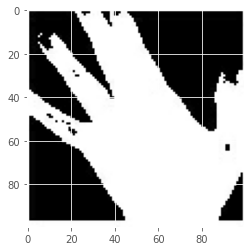

In [ ]:
for i in range(no_of_images):
  if(labels[i]==7):
    print(labels[i])
    plt.imshow(datas[i])
    break

In [ ]:
#Storing the training data as x_train and  y_train respectively
from sklearn.model_selection import train_test_split

X_train = datas 
Y_train=labels
print(X_train.shape)
print(Y_train.shape)


(4000, 100, 100, 3)
(4000,)


<h1>Collecting the testing data similary into X_test and Y_test</h1>

In [ ]:
#At first I am extracting the data into the tmp directory
import os
import zipfile
local_zip = '/content/drive/MyDrive/Thesis Final Works/trainData.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/test')
zip_ref.close()
#Using train_ds object to flow in all the images from the tmp directory
no_of_images=2000
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/tmp/test",
  validation_split=0,
  seed=123,
  image_size=(100, 100),
  batch_size=no_of_images)
#Printing the class names
class_names = test_ds.class_names
print(class_names)
#Collecting all the images in a large numpy array
#Collecting all the Corresponding image labels too 
#Both from the train_ds object
datas=None
labels=None
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  datas=image_batch
  labels=labels_batch
  break
#Dividing the image values by 255
datas=datas.numpy()/255.0
labels=labels.numpy()
#Printing the shape of data
print(datas[0].shape)
#Showing image
for i in range(no_of_images):
  if(labels[i]==7):
    print(labels[i])
    plt.imshow(datas[i])
    break
#Storing the training data as x_test and  y_test respectively
X_test = datas 
Y_test=labels
print(X_test.shape)
print(Y_test.shape)

<center><h1>Making the model</h1></center>

1.This function will return a sister network of the Siamese architecture


In [ ]:
# This function takes in the input shape and returns a siamese network model
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

2.Specifying some parameters for training purpose

In [ ]:
# specify the shape of the inputs for our network
IMG_SHAPE = (100, 100, 3)
# specify the batch size and number of epochs
BATCH_SIZE = 16
EPOCHS = 150


3.This function will pair up 2 images<br>
Assign '1' if they are same<br>
Assign '0' if they are different

In [ ]:
# This function will take all images and their labels
# It will pair up images and return for example [(img1,img2),(img1,img3)], [1,0]

def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

4.This  function will take feature maps from the two sster networks and provide the eucldian distance between them

In [ ]:
#It takes two vectors as tuples and place it in different lists
#Eucledian distance is calculated for the vectors
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

5.This function will be called by passing the history of training for plotting purposes

In [ ]:
#It takes in history from the model a path for storing the graph
#It creates an image and stores it in the plotpath
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

Preparing paired dataset

In [ ]:
(pairTrain, labelTrain) = make_pairs(X_train, Y_train)
(pairTest, labelTest) = make_pairs(X_test, Y_test)

In [ ]:
pairTrain[0].shape

(2, 100, 100, 3)

Assembling the Siamese network from the sister networks


In [ ]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

[INFO] building siamese network...


In [ ]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model


[INFO] compiling model...


In [ ]:
#More on
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/

filepath="/tmp/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
  callbacks=callbacks_list)

[INFO] training model...
Epoch 1/150
400/400 [==============================] - 6s 15ms/step - loss: 0.6944 - accuracy: 0.4876 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /tmp/weights-improvement-01-0.50.hdf5
Epoch 2/150
400/400 [==============================] - 6s 14ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.4550

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/150
400/400 [==============================] - 6s 14ms/step - loss: 0.6931 - accuracy: 0.5149 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/150
400/400 [==============================] - 6s 14ms/step - loss: 0.6932 - accuracy: 0.4816 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/150
400/400 [==============================] - 6s 14ms/step - loss: 0.6933 - accuracy: 0.4795 - val_loss: 0.693

[INFO] saving siamese model...
INFO:tensorflow:Assets written to: output/siamese_model/assets
[INFO] plotting training history...


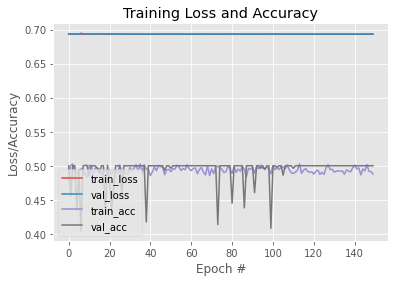

In [ ]:
# define the path to the base output directory
BASE_OUTPUT = "output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

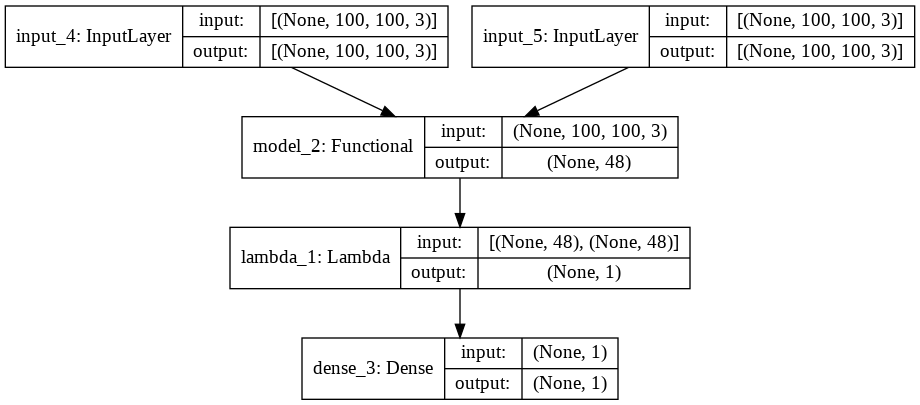

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)